In [1]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=02ec8fceeaa564e3caa1a12506ced682331916312fa518a9616acd673ccb8a88
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS
from pyspark.sql.functions import col, sum as spark_sum

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# spark config
spark = SparkSession.builder \
    .appName("book recommendation") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "2") \
    .config("spark.master", "local[2]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [5]:
import zipfile
# Extract the contents of the zip file
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

# Specify the path to the extracted files
data_path = '/content/data'

## Load Data

In [7]:
books = spark.read.load(os.path.join(data_path, 'books.csv'), format='csv', header=True, inferSchema=True)
ratings = spark.read.load(os.path.join(data_path, 'ratings.csv'), format='csv', header=True, inferSchema=True)

### basic inspection

In [8]:
books.show()

+-------+--------------------+--------------------+
|book_id|             authors|               title|
+-------+--------------------+--------------------+
|      1|     Suzanne Collins|The Hunger Games ...|
|      2|J.K. Rowling, Mar...|Harry Potter and ...|
|      3|     Stephenie Meyer|Twilight (Twiligh...|
|      4|          Harper Lee|To Kill a Mocking...|
|      5| F. Scott Fitzgerald|    The Great Gatsby|
|      6|          John Green|The Fault in Our ...|
|      7|      J.R.R. Tolkien|          The Hobbit|
|      8|       J.D. Salinger|The Catcher in th...|
|      9|           Dan Brown|Angels & Demons  ...|
|     10|         Jane Austen| Pride and Prejudice|
|     11|     Khaled Hosseini|     The Kite Runner|
|     12|       Veronica Roth|Divergent (Diverg...|
|     13|George Orwell, Er...|                1984|
|     14|       George Orwell|         Animal Farm|
|     15|Anne Frank, Elean...|The Diary of a Yo...|
|     16|Stieg Larsson, Re...|The Girl with the...|
|     17|   

In [9]:
ratings.show()

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
|      1|    258|     5|
|      2|   4081|     4|
|      2|    260|     5|
|      2|   9296|     5|
|      2|   2318|     3|
|      2|     26|     4|
|      2|    315|     3|
|      2|     33|     4|
|      2|    301|     5|
|      2|   2686|     5|
|      2|   3753|     5|
|      2|   8519|     5|
|      4|     70|     4|
|      4|    264|     3|
|      4|    388|     4|
|      4|     18|     5|
|      4|     27|     5|
|      4|     21|     5|
|      4|      2|     5|
|      4|     23|     5|
+-------+-------+------+
only showing top 20 rows



In [10]:
# Get the shape of the books dataset
books_shape = (books.count(), len(books.columns))
print("Books dataset shape:", books_shape)

# Get the shape of the ratings dataset
ratings_shape = (ratings.count(), len(ratings.columns))
print("Ratings dataset shape:", ratings_shape)

Books dataset shape: (10000, 3)
Ratings dataset shape: (5976479, 3)


In [11]:
# Check for missing values in the books dataset
missing_values_books = books.select([spark_sum(col(column).isNull().cast("int")).alias(column) for column in books.columns])
missing_values_count_books = missing_values_books.collect()[0]
print("Missing values in the Books dataset:")
for column, count in zip(books.columns, missing_values_count_books):
    print(f"{column}: {count}")

# Check for missing values in the ratings dataset
missing_values_ratings = ratings.select([spark_sum(col(column).isNull().cast("int")).alias(column) for column in ratings.columns])
missing_values_count_ratings = missing_values_ratings.collect()[0]
print("Missing values in the Ratings dataset:")
for column, count in zip(ratings.columns, missing_values_count_ratings):
    print(f"{column}: {count}")

Missing values in the Books dataset:
book_id: 0
authors: 0
title: 0
Missing values in the Ratings dataset:
user_id: 0
book_id: 0
rating: 0


In [12]:
books.describe().show()

+-------+------------------+--------------------+-----------------------------------+
|summary|           book_id|             authors|                              title|
+-------+------------------+--------------------+-----------------------------------+
|  count|             10000|               10000|                              10000|
|   mean|            5000.5|                NULL|                 1567.2857142857142|
| stddev|2886.8956799071675|                NULL|                 1010.0657922937024|
|    min|                 1|    A. Manette Ansay|                Angels (Walsh Fa...|
|    max|             10000|يوسف زيدان, Youss...|美少女戦士セーラームーン新装版 1...|
+-------+------------------+--------------------+-----------------------------------+



In [13]:
ratings.describe().show()

+-------+------------------+------------------+------------------+
|summary|           user_id|           book_id|            rating|
+-------+------------------+------------------+------------------+
|  count|           5976479|           5976479|           5976479|
|   mean|26224.457362102334|2006.4773984816143|3.9198655261735214|
| stddev| 15413.23409327275|2468.4994633795254|0.9910868103700692|
|    min|                 1|                 1|                 1|
|    max|             53424|             10000|                 5|
+-------+------------------+------------------+------------------+



What are the ratings?

In [14]:
print('Distinct values of ratings:')
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
[1, 2, 3, 4, 5]


What is minimum number of ratings per user and minimum number of ratings per book?

In [15]:
tmp1 = ratings.groupBy("user_id").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("book_id").count().toPandas()['count'].min()
print('For the users that rated books and the books that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per book is {}'.format(tmp2))

For the users that rated books and the books that were rated:
Minimum number of ratings per user is 19
Minimum number of ratings per book is 8


How many books are rated by only one user?

In [16]:
tmp1 = sum(ratings.groupBy("book_id").count().toPandas()['count'] == 1)
tmp2 = ratings.select('book_id').distinct().count()
print('{} out of {} books are rated by only one user'.format(tmp1, tmp2))

0 out of 10000 books are rated by only one user


What is the total number of users in the data sets?

In [17]:
tmp = ratings.select('user_id').distinct().count()
print('We have a total of {} distinct users in the data sets'.format(tmp))

We have a total of 53424 distinct users in the data sets


What is the total number of books in the data sets?

In [18]:
tmp = books.select('book_id').distinct().count()
print('We have a total of {} distinct books in the data sets'.format(tmp))

We have a total of 10000 distinct books in the data sets


How many books are rated by users? List movies not rated yet?

In [19]:
tmp1 = books.select('book_id').distinct().count()
tmp2 = ratings.select('book_id').distinct().count()
print('We have a total of {} distinct books that are rated by users in ratings table'.format(tmp2))
print('We have {} books that are not rated yet'.format(tmp1-tmp2))

We have a total of 10000 distinct books that are rated by users in ratings table
We have 0 books that are not rated yet


List all book authors

In [21]:
# define a udf for splitting the genres string
splitter = UserDefinedFunction(lambda x: x.split('|'), ArrayType(StringType()))
# query
print('All distinct authors: ')
books.select(explode(splitter("authors")).alias("authors")).distinct().show()

All distinct authors: 
+--------------------+
|             authors|
+--------------------+
|         Lisa Genova|
|          James Frey|
|              Banksy|
|Grant Morrison, D...|
|    Elin Hilderbrand|
|     Karen Armstrong|
|Thomas More, Paul...|
|        Mia Sheridan|
|         Kylie Scott|
|      Rosamund Hodge|
|Garth Ennis, Stev...|
|Isa Chandra Mosko...|
|          Dava Sobel|
|Fábio Moon, Gabri...|
|   Sharon Kay Penman|
|    Joshilyn Jackson|
|        Geoff Colvin|
|Maud Hart Lovelac...|
|         Bruce Degen|
|        Doug Stanton|
+--------------------+
only showing top 20 rows



Find out the number of books for each author

In [22]:
print('Counts of books per author')
books.select('book_id', explode(splitter("authors")).alias("authors")) \
    .groupby('authors') \
    .count() \
    .sort(desc('count')) \
    .show()

Counts of books per author
+-------------------+-----+
|            authors|count|
+-------------------+-----+
|       Stephen King|   60|
|       Nora Roberts|   59|
|        Dean Koontz|   47|
|    Terry Pratchett|   42|
|    Agatha Christie|   39|
|          Meg Cabot|   37|
|    James Patterson|   36|
|     David Baldacci|   34|
|       John Grisham|   33|
|          J.D. Robb|   33|
|Laurell K. Hamilton|   30|
|    Janet Evanovich|   30|
|   Michael Connelly|   29|
|      John Sandford|   28|
|     Kristen Ashley|   27|
|      Tamora Pierce|   26|
|       Harlan Coben|   25|
|  Patricia Cornwell|   25|
|   Sherrilyn Kenyon|   25|
|        Sue Grafton|   24|
+-------------------+-----+
only showing top 20 rows



## Spark ALS based approach for training model
1. Reload data
2. Split data into train, validation, test
3. ALS model selection and evaluation
4. Model testing

### Reload data
We will use an RDD-based API from pyspark.mllib to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.

In [23]:
# load data
book_rating = sc.textFile(os.path.join(data_path, 'ratings.csv'))
# preprocess data -- only need ["user_id", "book_id", "rating"]
header = book_rating.take(1)[0]
rating_data = book_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()
# check three rows
rating_data.take(3)

[(1, 258, 5.0), (2, 4081, 4.0), (2, 260, 5.0)]

### Split data
Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [24]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[189] at RDD at PythonRDD.scala:53

### ALS model selection and evaluation
With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [25]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [26]:
# hyper-param config
num_iterations = 10
ranks = [20,30,40]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

start_time = time.time()
print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

20 latent factors and regularization = 0.001: validation RMSE is 1.250745735800901
20 latent factors and regularization = 0.01: validation RMSE is 0.9682803673834399
20 latent factors and regularization = 0.05: validation RMSE is 0.8497245941002024
20 latent factors and regularization = 0.1: validation RMSE is 0.8258666839211418
20 latent factors and regularization = 0.2: validation RMSE is 0.8614423724862547
30 latent factors and regularization = 0.001: validation RMSE is 1.6633105258568468
30 latent factors and regularization = 0.01: validation RMSE is 1.0361808298113442
30 latent factors and regularization = 0.05: validation RMSE is 0.8575154810054164
30 latent factors and regularization = 0.1: validation RMSE is 0.8249246511276649
30 latent factors and regularization = 0.2: validation RMSE is 0.8610683102623479
40 latent factors and regularization = 0.001: validation RMSE is 2.014118223515485
40 latent factors and regularization = 0.01: validation RMSE is 1.082805936024296
40 laten

### ALS model learning curve
As we increase number of iterations in training ALS, we can see how RMSE changes and whether or not model is overfitted.

In [27]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

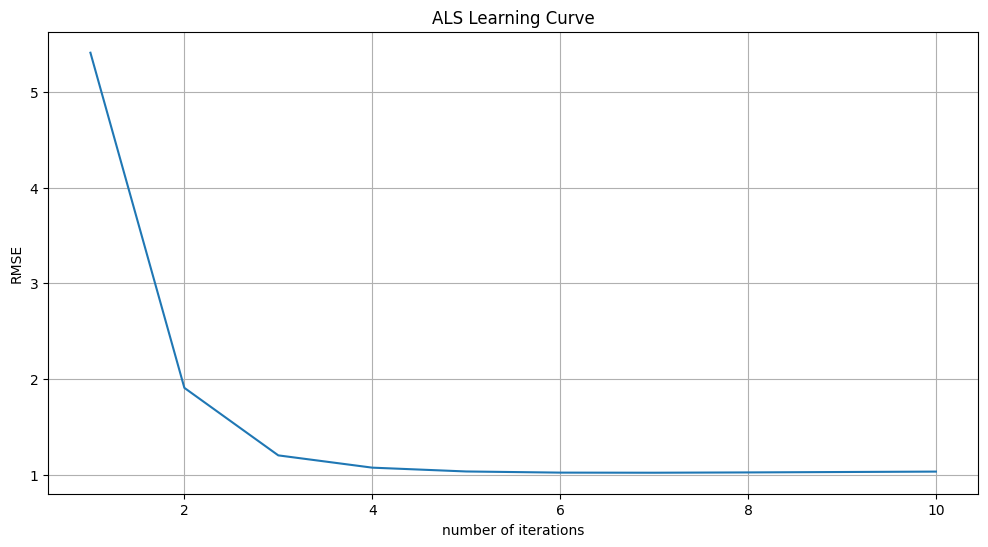

In [28]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.01, 30)

### Model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [29]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8259


### Make movie recommendation to myself
We need to define a function that takes new user's movie rating and output top 10 recommendations

In [30]:
def get_book_id(df_books, fav_book_list):
    """
    return all book_id(s) of user's favorite books

    Parameters
    ----------
    df_books: spark Dataframe, books data

    fav_book_list: list, user's list of favorite books

    Return
    ------
    book_id_list: list of book_Id(s)
    """
    book_id_list = []
    for book in fav_book_list:
        book_ids = df_books \
            .filter(books.title.like('%{}%'.format(book))) \
            .select('book_id') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        book_id_list.extend(book_ids)
    return list(set(book_id_list))

In [31]:
def add_new_user_to_data(train_data, book_id_list, spark_context):
    """
    add new rows with new user, user's book and ratings to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data

    book_id_list: list, list of book_id(s)

    spark_context: Spark Context object

    Return
    ------
    new train data with the new user's rows
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, book_id, max_rating) for book_id in book_id_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)

In [32]:
def get_inference_data(train_data, df_books, book_id_list):
    """
    return a rdd with the userid and all books (except ones in book_id_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    df_books: spark Dataframe, books data

    book_id_list: list, list of book_id(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return df_books.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in book_id_list) \
        .map(lambda x: (new_id, x))

In [33]:
def make_recommendation(best_model_params, ratings_data, df_books,
                        fav_book_list, n_recommendations, spark_context):
    """
    return top n book recommendation based on user's input list of favorite books


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    df_books: spark Dataframe, books data

    fav_book_list: list, user's list of favorite books

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n book recommendations
    """
    # modify train data by adding new user's rows
    book_id_list = get_book_id(df_books, fav_book_list)
    train_data = add_new_user_to_data(ratings_data, book_id_list, spark_context)

    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)

    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, df_books, book_id_list)

    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))

    # get top n movieId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]

    # return movie titles
    return df_books.filter(books.book_id.isin(topn_ids)) \
                    .select('title') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

Let's pretend I am a new user in this recommender system. I will input a handful of my all-time favorite books into the system. And then the system should output top N movie recommendations for me to watch

In [34]:
# my favorite book
my_favorite_books = ['The Shadow of the Wind']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 30, 'lambda_': 0.1},
    ratings_data=rating_data,
    df_books=books,
    fav_book_list=my_favorite_books,
    n_recommendations=10,
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_books[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for The Shadow of the Wind:
1: Book of Mormon, Doctrine and Covenants, Pearl of Great Price
2: Bakuman, Band 1: Traum und Realität
3: Bumi Manusia
4: Darth Vader and Son
5: A Different Blue
6: Red Notice: A True Story of High Finance, Murder, and One Man’s Fight for Justice
7: Superman for All Seasons
8: A Little History of the World
9: Attack of the Deranged Mutant Killer Monster Snow Goons
10: Economics in One Lesson: The Shortest & Surest Way to Understand Basic Economics
